In [19]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), 
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(3, stride=2),

    nn.Dropout(0.5),

    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

X = torch.rand([1, 1, 224, 224])
for layer in net:
    X = layer(X)
    print(f'{layer.__class__.__name__} -> \t {X.shape}')

Sequential -> 	 torch.Size([1, 96, 54, 54])
MaxPool2d -> 	 torch.Size([1, 96, 26, 26])
Sequential -> 	 torch.Size([1, 256, 26, 26])
MaxPool2d -> 	 torch.Size([1, 256, 12, 12])
Sequential -> 	 torch.Size([1, 384, 12, 12])
MaxPool2d -> 	 torch.Size([1, 384, 5, 5])
Dropout -> 	 torch.Size([1, 384, 5, 5])
Sequential -> 	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d -> 	 torch.Size([1, 10, 1, 1])
Flatten -> 	 torch.Size([1, 10])


loss 2.041, train acc 0.829, test acc 0.821
3364.5 examples/sec on cuda:0


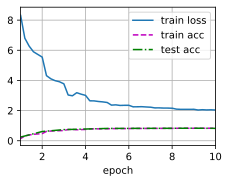

In [20]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
device = torch.device('cuda:0')
print('training on', device)
net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
timer = d2l.Timer()
num_batches = len(train_iter)

animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
        timer.start()
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()

        with torch.no_grad():
            metric.add(l*num_batches, d2l.accuracy(y_hat, y), X.shape[0])
        timer.stop()
        train_loss = metric[0]/metric[2]
        train_acc = metric[1]/metric[2]

        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None))
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter, device)
    animator.add(epoch + 1, (None, None, test_acc))
print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')


